In [1]:
import os, sys

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import argparse
import os
import copy

import numpy as np
import torch
from PIL import Image, ImageDraw, ImageFont
from torchvision.ops import box_convert
import torchvision
# Grounding DINO
import groundingdino.datasets.transforms as T
from groundingdino.models import build_model
from groundingdino.util import box_ops
from groundingdino.util.slconfig import SLConfig
from groundingdino.util.utils import clean_state_dict, get_phrases_from_posmap
from groundingdino.util.inference import annotate, load_image, predict

import supervision as sv

# segment anything
from segment_anything import build_sam, SamPredictor,SamAutomaticMaskGenerator
import cv2
import numpy as np
import matplotlib.pyplot as plt


# diffusers
import PIL
import requests
import torch
from io import BytesIO
from diffusers import StableDiffusionInpaintPipeline

from huggingface_hub import hf_hub_download
from tag2text.models import tag2text
from tag2text import inference
import torchvision.transforms as TS

from groundingdino.util.inference import Model
from segment_anything import sam_model_registry, SamPredictor

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
sam_checkpoint = '/home/diksha/cv_experiment2/cv_experiment/models/sam_vit_h_4b8939.pth'
sam = build_sam(checkpoint=sam_checkpoint)
sam.to(device=device)
sam_predictor = SamPredictor(sam)

In [55]:
from groundingdino.util.inference import Model

image = cv2.imread('/home/diksha/ryan.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
GROUNDING_DINO_CONFIG_PATH = "/home/diksha/cv_experiment2/cv_experiment/configs/GroundingDINO_SwinT_OGC.py" 
GROUNDING_DINO_CHECKPOINT_PATH = "/home/diksha/cv_experiment2/cv_experiment/models/groundingdino_swint_ogc.pth"
BOX_THRESHOLD=0.5
TEXT_THRESHOLD=0.4
grounding_dino_model = Model(
    model_config_path=GROUNDING_DINO_CONFIG_PATH, 
    model_checkpoint_path=GROUNDING_DINO_CHECKPOINT_PATH)

with open("/home/diksha/cv_experiment2/cv_experiment/data/tag_list.txt") as f:
    automatic_classes = f.readlines()
    automatic_classes = [s.strip() for s in automatic_classes]

detections = [grounding_dino_model.predict_with_classes(
    image=image,
    classes=automatic_classes[i:i+200],
    box_threshold=BOX_THRESHOLD,
    text_threshold=TEXT_THRESHOLD
) for i in range(0, len(automatic_classes), 200)]
all_detections = []
for i, sublist in enumerate(detections):
    for det in sublist:
        det_list = list(det)
        det_list[3] = automatic_classes[200*i + det_list[3]]
        det = tuple(det_list)
        all_detections.append(det)

final text_encoder_type: bert-base-uncased


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [56]:
import torchvision
IOU_THRESHOLD = 0.5
nms_idx = torchvision.ops.nms(
    torch.from_numpy(np.array([detection[0] for detection in all_detections])), 
    torch.from_numpy(np.array([detection[2] for detection in all_detections])), 
    IOU_THRESHOLD
).numpy().tolist()
new_detections = [all_detections[idx] for idx in nms_idx]

In [57]:
def segment(sam_predictor: SamPredictor, image: np.ndarray, xyxy: np.ndarray) -> np.ndarray:
    sam_predictor.set_image(image)
    result_masks = []
    for box in xyxy:
        masks, scores, logits = sam_predictor.predict(
            box=box,
            multimask_output=True
        )
        index = np.argmax(scores)
        result_masks.append(masks[index])
    return np.array(result_masks)
masks = segment(
    sam_predictor=sam_predictor,
    image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB),
    xyxy=[det[0] for det in new_detections]
)


In [63]:
mask_generator = SamAutomaticMaskGenerator(sam)
all_masks = mask_generator.generate(image)
sorted_masks = sorted(all_masks, key=lambda unclass: unclass['area'],reverse=True)
print(sorted_masks[0])

{'segmentation': array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]]), 'area': 572979, 'bbox': [0, 0, 1461, 1567], 'predicted_iou': 1.0005580186843872, 'point_coords': [[68.625, 396.5]], 'stability_score': 0.9799268245697021, 'crop_box': [0, 0, 1464, 1952]}


In [80]:
already_classified = []
not_classified = []
from copy import deepcopy
total_masks = deepcopy(masks)
for mask_sam in sorted_masks:
    mask_sam_segmentaion = mask_sam['segmentation']
    is_present = False
    for mask_grounding_dino in total_masks:
        complete_area = (np.count_nonzero(mask_sam_segmentaion))
        area_without_grounding_dino = (np.count_nonzero(np.logical_and(mask_sam_segmentaion, np.logical_not(mask_grounding_dino))))
        if area_without_grounding_dino/complete_area < 0.8:
            is_present = True
            break
    if not is_present:
        total_masks = np.append(total_masks, [mask_sam['segmentation']], axis=0)
        not_classified.append(mask_sam)
    else:
        already_classified.append(mask_sam)


Found something
Found something
Found something
Found something
Found something
Found something
Found something
Found something
Found something
Found something
Found something
Found something
Found something
Found something
Found something
Found something
Found something
Found something
Found something
Found something
Found something
Found something
Found something
Found something
Found something
Found something
Found something
Found something
Found something
Found something
Found something
Found something
Found something
Found something
Found something
Found something
Found something
Found something
Found something
Found something
Found something
Found something
Found something
Found something
Found something
Found something
Found something
Found something
Found something
Found something
Found something
Found something
Found something
Found something
Found something
Found something
Found something
Found something
Found something
Found something
Found something
Found something
Found so

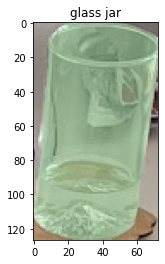

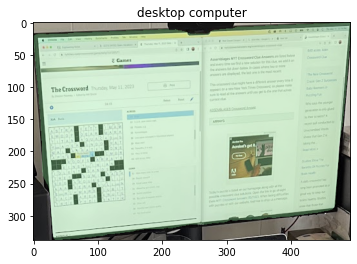

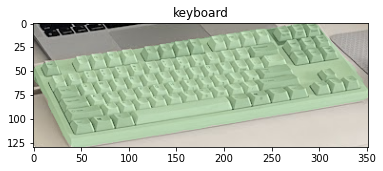

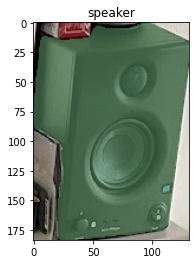

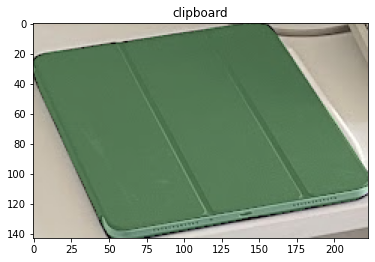

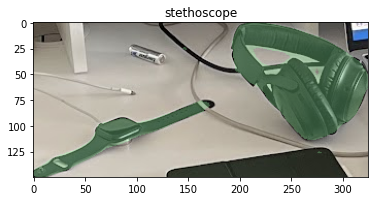

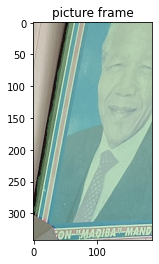

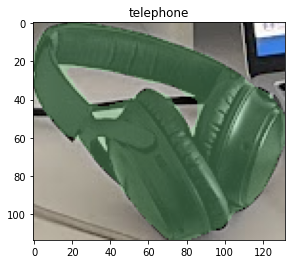

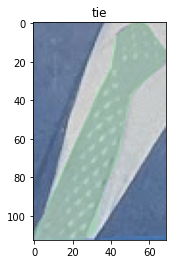

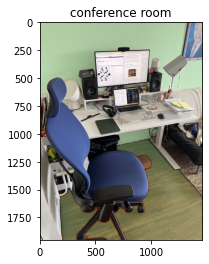

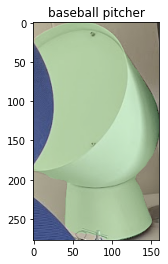

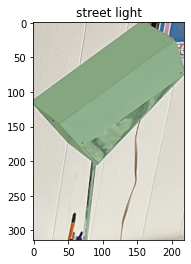

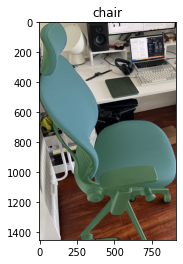

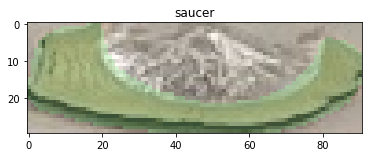

[0.5631324549783675, 0.9331862778042509, 0.6144558745808524]


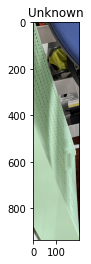

[0.5631324549783675, 0.9331862778042509, 0.6144558745808524]


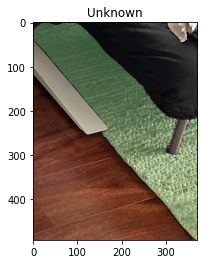

[0.5631324549783675, 0.9331862778042509, 0.6144558745808524]


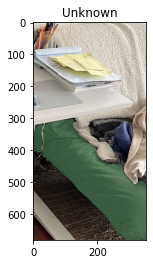

[0.5631324549783675, 0.9331862778042509, 0.6144558745808524]


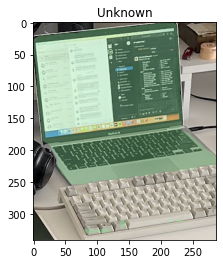

[0.5631324549783675, 0.9331862778042509, 0.6144558745808524]


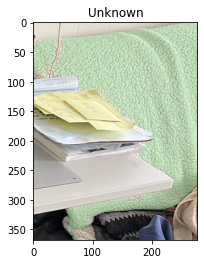

[0.5631324549783675, 0.9331862778042509, 0.6144558745808524]


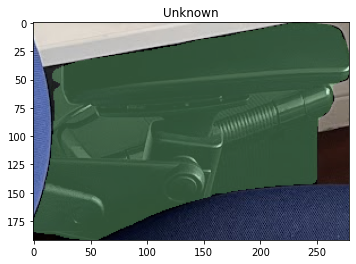

[0.5631324549783675, 0.9331862778042509, 0.6144558745808524]


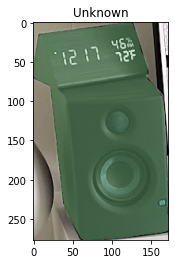

[0.5631324549783675, 0.9331862778042509, 0.6144558745808524]


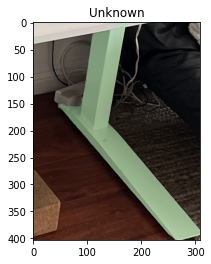

[0.5631324549783675, 0.9331862778042509, 0.6144558745808524]


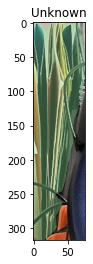

[0.5631324549783675, 0.9331862778042509, 0.6144558745808524]


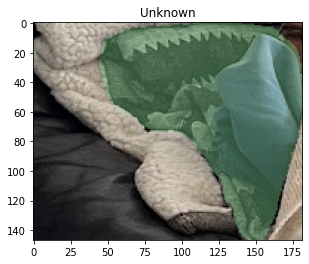

[0.5631324549783675, 0.9331862778042509, 0.6144558745808524]


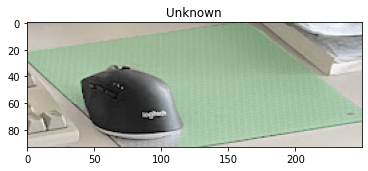

[0.5631324549783675, 0.9331862778042509, 0.6144558745808524]


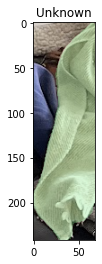

[0.5631324549783675, 0.9331862778042509, 0.6144558745808524]


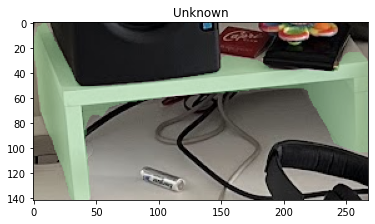

[0.5631324549783675, 0.9331862778042509, 0.6144558745808524]


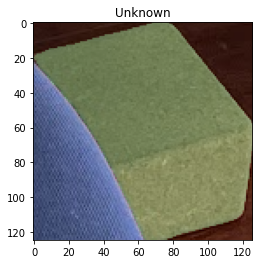

[0.5631324549783675, 0.9331862778042509, 0.6144558745808524]


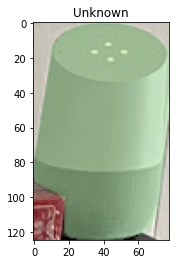

[0.5631324549783675, 0.9331862778042509, 0.6144558745808524]


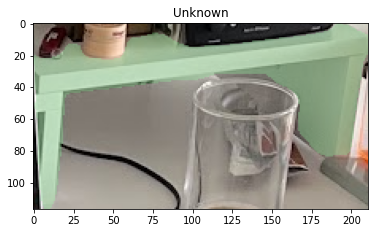

[0.5631324549783675, 0.9331862778042509, 0.6144558745808524]


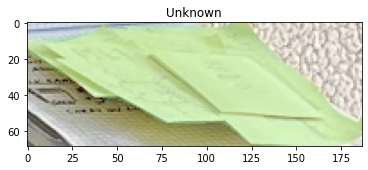

[0.5631324549783675, 0.9331862778042509, 0.6144558745808524]


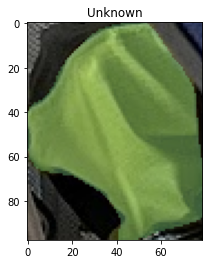

[0.5631324549783675, 0.9331862778042509, 0.6144558745808524]


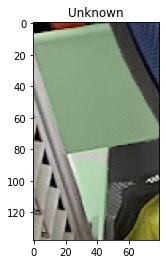

[0.5631324549783675, 0.9331862778042509, 0.6144558745808524]


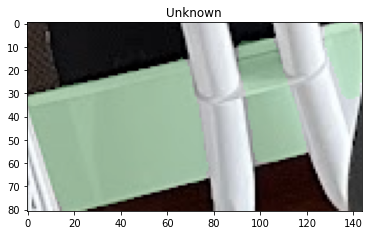

[0.5631324549783675, 0.9331862778042509, 0.6144558745808524]


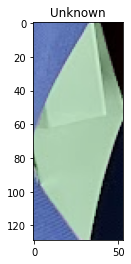

[0.5631324549783675, 0.9331862778042509, 0.6144558745808524]


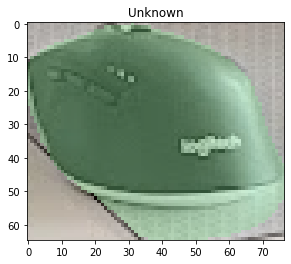

[0.5631324549783675, 0.9331862778042509, 0.6144558745808524]


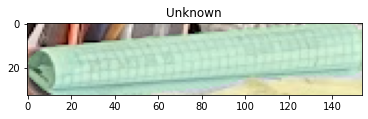

[0.5631324549783675, 0.9331862778042509, 0.6144558745808524]


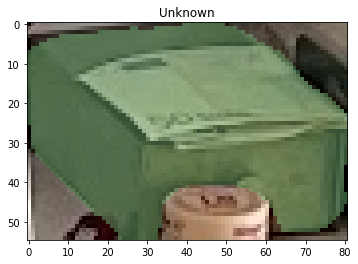

[0.5631324549783675, 0.9331862778042509, 0.6144558745808524]


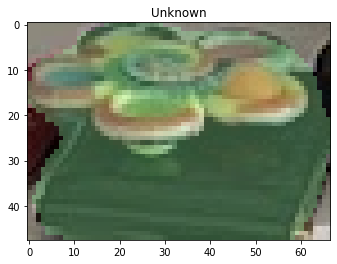

[0.5631324549783675, 0.9331862778042509, 0.6144558745808524]


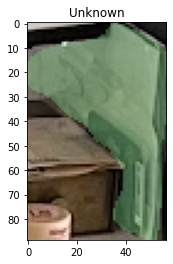

[0.5631324549783675, 0.9331862778042509, 0.6144558745808524]


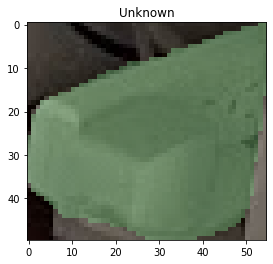

[0.5631324549783675, 0.9331862778042509, 0.6144558745808524]


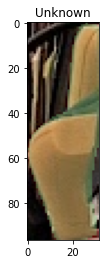

[0.5631324549783675, 0.9331862778042509, 0.6144558745808524]


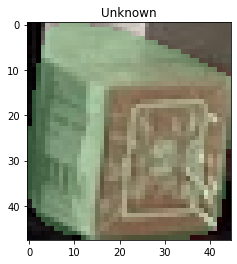

[0.5631324549783675, 0.9331862778042509, 0.6144558745808524]


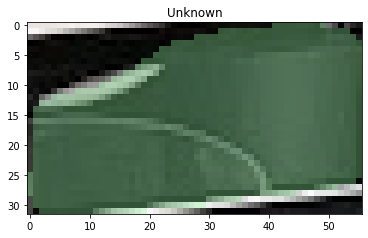

[0.5631324549783675, 0.9331862778042509, 0.6144558745808524]


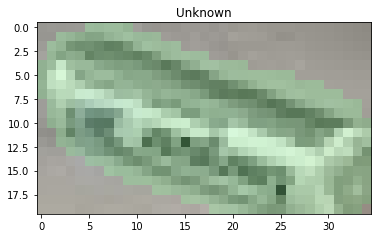

In [81]:
def bbox(img):
    img = (img > 0)
    rows = np.any(img, axis=1)
    cols = np.any(img, axis=0)
    rmin, rmax = np.argmax(rows), img.shape[0] - 1 - np.argmax(np.flipud(rows))
    cmin, cmax = np.argmax(cols), img.shape[1] - 1 - np.argmax(np.flipud(cols))
    return rmin, rmax, cmin, cmax
color_mask = [0.5631324549783675, 0.9331862778042509, 0.6144558745808524]

for j,mask in enumerate(masks):
    x1,x2,y1,y2 = bbox(mask)
    cropped_image = image[x1:x2, y1:y2]
    cropped_mask = mask[x1:x2, y1:y2]
    img = np.ones((cropped_mask.shape[0], cropped_mask.shape[1], 3))
    for i in range(3):
        img[:,:,i] = color_mask[i]
    plt.imshow(cropped_image)
    ax = plt.gca()
    ax.set_autoscale_on(False)
    ax.imshow(np.dstack((img, cropped_mask*0.35)))
    plt.title(new_detections[j][3])
    plt.show()

for unclassified in not_classified:
    x1,x2,y1,y2 = bbox(unclassified['segmentation'])
    mask = unclassified['segmentation']
    cropped_image = image[x1:x2, y1:y2]
    cropped_mask = mask[x1:x2, y1:y2]
    img = np.ones((cropped_mask.shape[0], cropped_mask.shape[1], 3))
    for i in range(3):
        img[:,:,i] = color_mask[i]
    plt.imshow(cropped_image)
    ax = plt.gca()
    ax.set_autoscale_on(False)
    ax.imshow(np.dstack((img, cropped_mask*0.35)))
    plt.title('Unknown')
    plt.show()
    
 


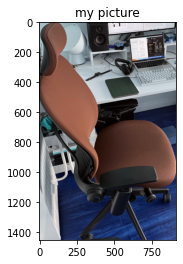

In [13]:
cropped_image = cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB)
plt.imshow(cropped_image)
plt.title('my picture')
plt.show()


In [38]:
arr = np.zeros((14, 1952, 1464))
arr2 = np.zeros((1952, 1464))
(arr + arr2).shape

(14, 1952, 1464)

In [69]:
print(all_masks[0])
print([mask['predicted_iou'] for mask in all_masks])

{'segmentation': array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]]), 'area': 528046, 'bbox': [183, 1052, 1277, 899], 'predicted_iou': 1.0226494073867798, 'point_coords': [[709.125, 1677.5]], 'stability_score': 0.9833996891975403, 'crop_box': [0, 0, 1464, 1952]}
[1.0226494073867798, 1.018998146057129, 1.0164467096328735, 1.0124220848083496, 1.0096516609191895, 1.008741855621338, 1.0032943487167358, 1.002916932106018, 1.0023747682571411, 1.0005580186843872, 0.9996296167373657, 0.9992257952690125, 0.9991928935050964, 0.9976676106452942, 0.996842622756958, 0.9961061477661133, 0.9952532649040222, 0.9945172071456909, 0.9940271973609924, 0.9927266240119934, 0.9924530386924744, 0.9923906326293945, 0.9